In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.naive_bayes import MultinomialNB
import string

from random import randint
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, recall_score, precision_score,f1_score
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"













In [2]:
#read my csv
df = pd.read_excel('df2.xlsx')

In [3]:
print(df.head(3))

                                   title     citation  \
0                       Brands Act, 1913  Chapter 244   
1  Authentication of Documents Act, 1914   Chapter 75   
2     Lands and Deeds Registry Act, 1914  Chapter 185   

                                             content  
0  e document Zambia Chapter 244 Commenced on 1 N...  
1   document Zambia Chapter 75 Commenced on 21 Fe...  
2  e document Zambia Chapter 185 There are multip...  


In [4]:
# Replace NaN values in 'content' column with empty string
df['content'] = df['content'].fillna('')

# Create a boolean mask for rows containing "Loading PDF..." in column 'content'
mask = df['content'].str.contains('Loading PDF...')

# Filter the dataframe to keep only rows where the mask is False
df_filtered = df[~mask]

# Remove duplicates based on all columns
df_filtered = df_filtered.drop_duplicates()

# Create a new column 'categories' and assign the appropriate category for each row
df_filtered.loc[df_filtered['title'].str.contains('Act'), 'categories'] = 'ACT of Parliament'
df_filtered.loc[df_filtered['title'].str.contains('Statutory Instrument'), 'categories'] = 'Statutory Instrument'
df_filtered.loc[df_filtered['title'].str.contains('Repeal'), 'categories'] = 'Bill'
df_filtered.loc[~df_filtered['title'].str.contains('Amendment|Act|Repeal'), 'categories'] = 'Statutory Instrument'
df_filtered.loc[df_filtered['categories'].isnull(), 'categories'] = 'Bill'

# Write the filtered and categorized dataframe to a new Excel file
df_filtered.to_excel('df2_filtered_categorized.xlsx', index=False)


# Label Encoding the Classes

In [5]:
# Use pandas to pluck out abstracts
posts = pd.read_excel('df2_filtered_categorized.xlsx')

In [6]:
posts = posts.drop('citation', axis=1)

In [7]:
print(posts.head(3))

                                   title  \
0                       Brands Act, 1913   
1  Authentication of Documents Act, 1914   
2     Lands and Deeds Registry Act, 1914   

                                             content         categories  
0  e document Zambia Chapter 244 Commenced on 1 N...  ACT of Parliament  
1   document Zambia Chapter 75 Commenced on 21 Fe...  ACT of Parliament  
2  e document Zambia Chapter 185 There are multip...  ACT of Parliament  


In [8]:
posts['Xs'] =  posts.title +' '+ posts.content #creat new column 'Xs'
posts['Y'] = LabelEncoder().fit(posts.categories.unique()).transform(posts.categories) #label encode

posts = posts[['Xs','Y','categories']] # Drop 'title' and 'content'

In [9]:
#inspect the dataframe
posts.columns
posts.sample(5)

Index(['Xs', 'Y', 'categories'], dtype='object')

,Xs,Y,categories
85,"Societies Act, 1957 (295.4 KB) Search Navigate...",0,ACT of Parliament
426,NaN,2,Statutory Instrument
228,"National Savings and Credit Act, 1972 e docume...",0,ACT of Parliament
179,"Referendum Act, 1967 n Download Download PDF (...",0,ACT of Parliament
350,"Bank of Zambia Act, 1996 arch Navigate documen...",0,ACT of Parliament


In [10]:
post_content = posts.Xs
print('There are a total of {} posts'.format(len(post_content)))

index = randint(0,20)  #only inspect posts from the first 20 in the list
post_content[index]

There are a total of 474 posts


"Deceased Brother's Widow's Marriage Act, 1926  document Zambia Chapter 57 Commenced on 12 October 1926 [This is the "

# Viewing the post distribution in relation to Classes

categories
ACT of Parliament       369
Bill                     35
Statutory Instrument     70
Name: categories, dtype: int64

<AxesSubplot:ylabel='categories'>

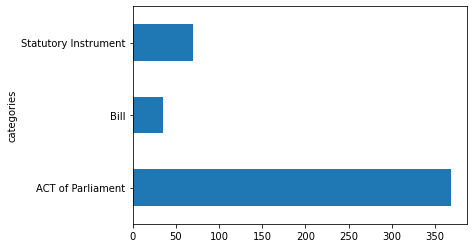

In [11]:
#inspecting the distribution of comments
posts.groupby('categories').categories.count()
posts.groupby('categories').categories.count().plot.barh()

# Cleaning the posts
1. drop NaN records
2. make all words into lower case
3. remove punctuations and numbers
4. remove stopwords
5. stemming

In [12]:
# 2. Case Folding
# Good idea to implement a function here [...]

def func_post_case_folding(contentText):
    return contentText.lower()


In [13]:
# 3. Punctuation
# Function for removing punctuations from string of text
def func_post_punctuation(contentText):
    
    #replace special charactors with ' '
    contentText_out = re.sub('[^\w\s]', ' ',contentText)
    contentText_out = re.sub('_', '',contentText_out)
    
    #change any whitespace to one space
    contentText_out = re.sub('\s+', ' ',contentText_out)
    
    #remove start and end whitespaces
    contentText_out = contentText_out.strip()
    
    contentText_out = re.sub('\w*\d\w*', '', contentText_out) # replace digits
    return contentText_out

In [14]:
# 5. Stemming
# Function for removing stopwords from string of text
# Remember: input will be chunck of text
def func_post_stem(contentText):
    var_stemmer = PorterStemmer()
    contentText_out = " ".join([
        var_stemmer.stem(contentText_word) for contentText_word in contentText.split() 
    ])
    return contentText_out

In [15]:
# Uncomment this line to download the stopwords list (only need to run once)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jonas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
# Function for removing stopwords from string of text
def func_post_stopwords(contentText_in):
    stop_words = set(stopwords.words('english'))
    contentText_out = " ".join([
        contentText_word for contentText_word in contentText_in.split() 
        if contentText_word.lower() not in stop_words
    ])
    return contentText_out

In [17]:
# 6. form the corpus

def func_get_all_words(content_list):
    all_words = []
    for item in content_list:
        for n in item.split():
            all_words.append(n)
    return all_words

In [18]:
# 7. Term Frequency 

def func_tf_transform(all_words_list,clean_content_list):
    var_transformed_dataset = []
    for item in clean_content_list:
        #print (var_etd_entry)
        var_dataset = []
        var_tokens = item.split()
        for x in all_words_list:
            #print (var_dictionary_entry)
            var_dataset.append(var_tokens.count(x[0]))
        var_transformed_dataset.append(var_dataset)
    return var_transformed_dataset

In [19]:
# function for functions to carry out step 2 to 5
# Function for removing stopwords from string of text

def func_clean_posts(content_list):
    
    temp_list = []
    for item in content_list:
        itemOut = func_post_case_folding(item)
        itemOut = func_post_punctuation(itemOut)
        itemOut = func_post_stopwords(itemOut)
        itemOut = func_post_stem(itemOut)
        
        temp_list.append(itemOut)
        
    return temp_list

In [20]:
post_content.dropna(inplace= True)
post_content_list = list(post_content)

In [21]:
#for the pusrpose of demostration, we will only clean 20 posts
clean_post_content_list = func_clean_posts(post_content_list)

In [22]:
clean_post_content_list[index]

'deceas brother widow marriag act document zambia chapter commenc octob'

In [23]:
#Check the length of the post before and after text cleaning.
len(post_content[index])
len(clean_post_content_list[index])

116

70

# Save the clean posts to Excel


In [24]:
print(len(posts))  # should be 517
print(len(clean_post_content_list))  # should also be 517

474
375


In [25]:
cleanPosts = posts

In [26]:
cleanPosts.dropna(subset=['Xs'], inplace=True)


In [27]:
print(cleanPosts.Xs)

0      Brands Act, 1913 e document Zambia Chapter 244...
1      Authentication of Documents Act, 1914  documen...
2      Lands and Deeds Registry Act, 1914 e document ...
3      Cotton Act, 1914 e document Zambia Chapter 227...
4      Witchcraft Act, 1914  document Zambia Chapter ...
                             ...                        
374    Customs and Excise (Raw Hides and Skins) (Expo...
375    Customs and Excise (Copper Ores and Concentrat...
376    Customs and Excise (Precious Metals) (Export D...
377    Customs and Excise (Ethyl Alcohol) (Refunds, R...
378    Customs and Excise (Customs Duty) (Suspension)...
Name: Xs, Length: 375, dtype: object


In [28]:
cleanPosts.Xs = clean_post_content_list
cleanPosts.to_excel('cleanPostClassification_no_numerics.xlsx')

In [29]:
print(len(posts))  # should be 371
print(len(clean_post_content_list))  # should also be 371

375
375


# Load the cleaned data from the excel

In [30]:
cleanPosts = pd.read_excel('cleanPostClassification_no_numerics.xlsx')
clean_post_content_list = list(cleanPosts.Xs)

In [31]:
cleanPosts.sample(3)  #Sampling the imported clean texts.

,Unnamed: 0,Xs,Y,categories
345,349,nation pension scheme act gislat download down...,0,ACT of Parliament
260,264,account act kb relat document repeal search na...,0,ACT of Parliament
268,272,nation youth develop council act e document za...,0,ACT of Parliament


In [32]:
#checking the frequence of the most common top 20 words
Counter(func_get_all_words(clean_post_content_list)).most_common(20)

[('shall', 6505),
 ('may', 3823),
 ('person', 3059),
 ('section', 1638),
 ('offic', 1623),
 ('court', 1598),
 ('order', 1556),
 ('minist', 1471),
 ('board', 1324),
 ('member', 1247),
 ('zambia', 1225),
 ('b', 1180),
 ('document', 1169),
 ('subsect', 1086),
 ('part', 1080),
 ('applic', 1043),
 ('made', 904),
 ('provis', 890),
 ('time', 851),
 ('author', 813)]

# Labels and Feature extraction

In [33]:
# generates a dataframe of the mapping between Class and labels(Y)

Label_categories_df = cleanPosts[['categories', 'Y']].drop_duplicates().sort_values('Y').reset_index().drop(columns='index')
Label_categories_df

,categories,Y
0,ACT of Parliament,0
1,Bill,1
2,Statutory Instrument,2


In [34]:
#Learning the vocabulary

# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()
vectorizer.fit(clean_post_content_list)

TfidfVectorizer()

In [35]:
#getting the tf-idf features and feature names

features = vectorizer.transform(clean_post_content_list)
features_columns = vectorizer.get_feature_names()

C:\Users\jonas\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
#create a pandas dataframe

features_df = pd.DataFrame(features.toarray(), columns = features_columns)
features_df.shape

(375, 5117)

In [37]:
#train_test_split?
x_train, x_test, y_train, y_test = train_test_split(features_df, cleanPosts['Y'], test_size=0.10)
len(x_train)
len(x_test)

337

38

In [38]:
# Performing CV to tune parameters for best SVM fit
model = LinearSVC()
# model = LogisticRegression(multi_class= 'auto')
model.fit(x_train, y_train)

LinearSVC()

In [39]:
model.score(x_test, y_test)
y_pred = model.predict(x_test)

0.9473684210526315

<AxesSubplot:>

Text(32.99999999999999, 0.5, 'Actual')

Text(0.5, 15.0, 'Predicted')

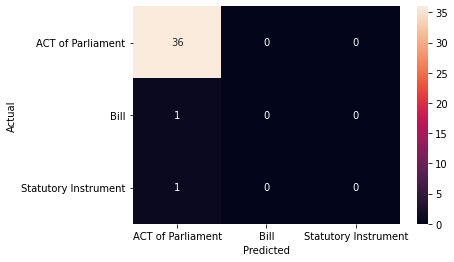

In [40]:
# creating the confusion matrix

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=Label_categories_df.categories.values, yticklabels=Label_categories_df.categories.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [41]:
print(classification_report(y_test, y_pred,target_names= Label_categories_df.categories.values ))

                      precision    recall  f1-score   support

   ACT of Parliament       0.95      1.00      0.97        36
                Bill       0.00      0.00      0.00         1
Statutory Instrument       0.00      0.00      0.00         1

            accuracy                           0.95        38
           macro avg       0.32      0.33      0.32        38
        weighted avg       0.90      0.95      0.92        38



C:\Users\jonas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# Use cross_val_score function
# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the dat
# cv=10 for 10 folds
# scoring='accuracy' for evaluation metric - althought they are many
scores = cross_val_score(model,features_df, cleanPosts['Y'], cv=10, scoring='accuracy')
print(scores)

C:\Users\jonas\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


[0.94736842 0.94736842 0.94736842 0.94736842 0.94736842 0.97297297
 0.97297297 0.97297297 0.97297297 0.94594595]


In [43]:
print('The Cross-validation score is {}'.format(scores.mean()))

The Cross-validation score is 0.9574679943100997
